In [ ]:
import os
import PyPDF2
from collections import Counter
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import pycountry
import geopandas as gpd
import matplotlib.patches as mpatches

Text Mapping from PDF files

In [30]:
#Iterate words from pdf files

def extract_text_until_references(pdf_path):
    """Extract text from a single PDF file, stopping when 'References' or 'Bibliography' is found."""
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ''
        for page in range(len(reader.pages)):
            page_text = reader.pages[page].extract_text()
            
            # Check for 'References' or 'Bibliography' in a case-insensitive manner
            if 'references' in page_text.lower() or 'bibliography' in page_text.lower():
                lower_text = page_text.lower()
                ref_index = lower_text.find('references') if 'references' in lower_text else lower_text.find('bibliography')
                text += page_text[:ref_index]  # Only include text up to the found reference point
                break
            
            text += page_text
    return text

def count_specific_words(text, words_to_count):
    """Count the occurrences of specific words in the text."""
    word_count = Counter()
    text = text.lower()  # Make the text lowercase for case-insensitive matching
    for word in words_to_count:
        word_count[word] = text.count(word.lower())  # Count occurrences of each word
    return word_count

def extract_and_count_from_folder(folder_path, words_to_count):
    """Extract text from all PDFs in a folder and count occurrences of specific words."""
    pdf_word_counts = {word: 0 for word in words_to_count}  # Initialize count dictionary
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.pdf'):
            pdf_path = os.path.join(folder_path, filename)
            pdf_text = extract_text_until_references(pdf_path)
            word_count = count_specific_words(pdf_text, words_to_count)
            
            # Update the total counts
            for word in words_to_count:
                pdf_word_counts[word] += word_count[word]
    
    return pdf_word_counts



In [31]:
# Specify the path to the folder containing PDFs
pdf_folder_path = r'C:\Users\DELL\Desktop\AGROECOSYSTEM\Touse'  

# Define the list of specific words you want to count
words_to_count = [
    'climate change', 'greenhouse gases', 'global warming', 'carbon footprint', 
    'sea level rise', 'emission reduction', 'renewable energy', 'climate adaptation', 
    'carbon sequestration', 'climate mitigation', 'temperature anomalies', 'weather extremes', 'extreme weather', 'extreme weather events',
    'climate extremes', 'heatwaves', 'drought', 'flooding', 'hurricanes', 
    'tornadoes', 'extreme precipitation', 'cold spells', 'storm surges', 'wildfires', 
    'ice storms', 'ecosystem service', 'pollination', 'water purification', 
    'soil fertility', 'carbon storage', 'climate regulation', 'biodiversity', 
    'erosion control', 'pest regulation', 'nutrient cycling', 'recreation', 
    'agroecosystem', 'crop rotation', 'sustainable agriculture', 'soil management', 
    'integrated pest management', 'agroforestry', 'cover crops', 'precision farming', 
    'organic farming', 'irrigation systems', 'livestock management', 
    'environmental stability', 'ecological balance', 'biodiversity conservation', 
    'habitat preservation', 'resilience', 'ecosystem health', 'sustainability', 
    'land use planning', 'pollution control', 'resource management', 
    'restoration ecology'
]

# Extract text from all PDFs and count the occurrences of specific words
pdf_word_counts = extract_and_count_from_folder(pdf_folder_path, words_to_count)

# Create a DataFrame and save it to a CSV file
csv_file_path = os.path.join(pdf_folder_path, 'word_counts_summary.csv')
df = pd.DataFrame(list(pdf_word_counts.items()), columns=['Word', 'Total Count'])
df.to_csv('word_counts_summary.csv', index=False)

In [32]:
df.head(5)

,Word,Total Count
0,climate change,947
1,greenhouse gases,17
2,global warming,114
3,carbon footprint,1
4,sea level rise,3


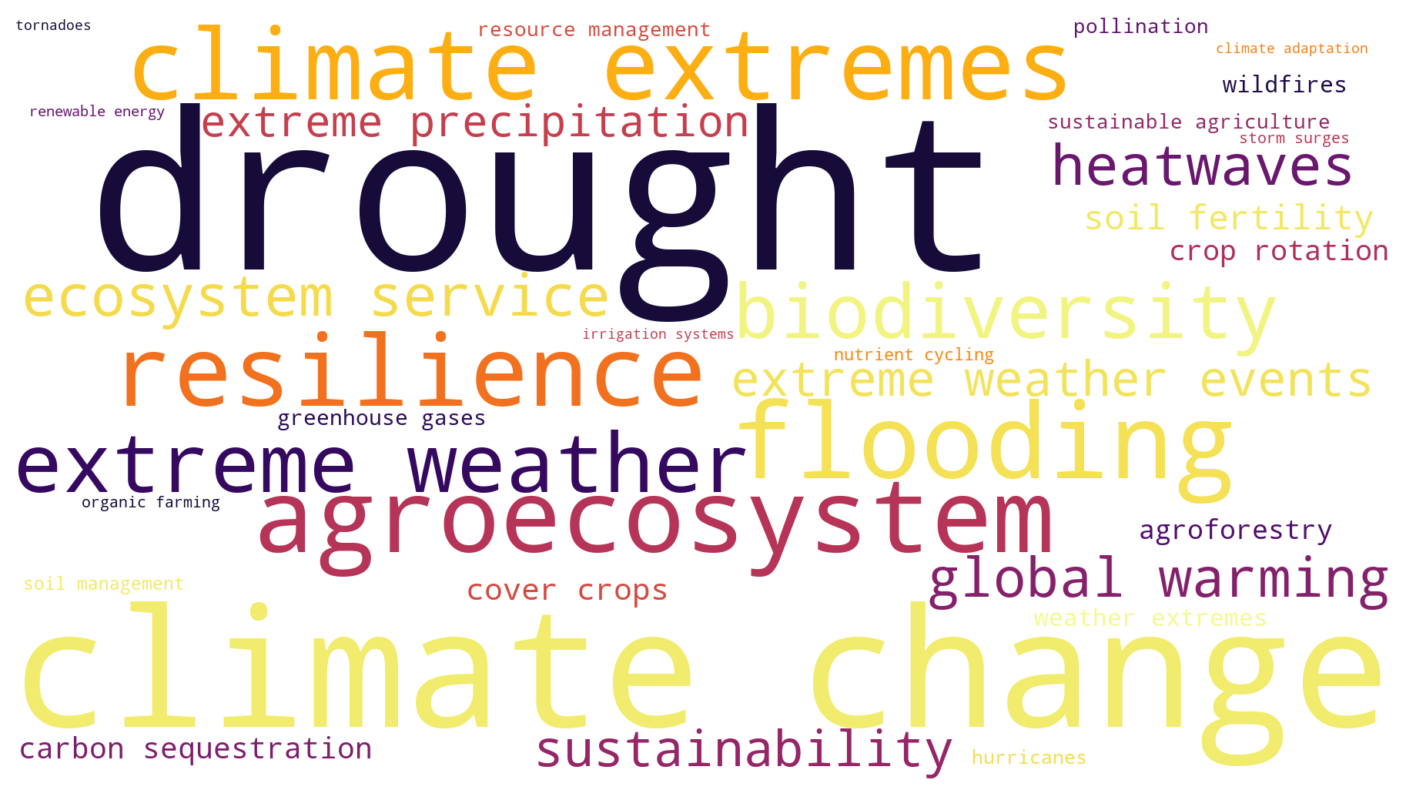

In [ ]:
# Create a dictionary from the DataFrame for WordCloud
word_freq = dict(zip(df['Word'], df['Total Count']))

# Create a word cloud with specified dimensions and minimum font size
wordcloud = WordCloud(
    width=1800, 
    height=1000, 
    background_color='white', 
    colormap="inferno",
    min_font_size=16  # Ensure least frequent words are readable
).generate_from_frequencies(word_freq)

# Display the word cloud using matplotlib
plt.figure(figsize=(18, 10))  # Adjust the figure size to match the word cloud resolution
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()

In [36]:
# Create a dictionary mapping words to their respective keyword groups
keyword_groups = {
    'Climate Change': ['Climate Change', 'Greenhouse gases', 'Global warming', 'Carbon footprint', 'Sea level rise', 
                       'Emission reduction', 'Renewable energy', 'Climate adaptation', 'Carbon sequestration', 
                       'Climate mitigation', 'Temperature anomalies'],
    
    'Climate Extremes': ['weather extremes', 'extreme weather', 'extreme weather events', 'Climate Extremes', 
                         'Heatwaves', 'Drought', 'Flooding', 'Hurricanes', 'Tornadoes', 'Extreme precipitation', 
                         'Cold spells', 'Storm surges', 'Wildfires', 'Ice storms'],
    
    'Ecosystem Services': ['Ecosystem Service', 'Pollination', 'Water purification', 'Soil fertility', 'Carbon storage', 
                           'Climate regulation', 'Biodiversity', 'Erosion control', 'Pest regulation', 'Nutrient cycling', 
                           'Recreation'],
    
    'Agroecosystem': ['Agroecosystem', 'Crop rotation', 'Sustainable agriculture', 'Soil management', 
                      'Integrated pest management', 'Agroforestry', 'Cover crops', 'Precision farming', 
                      'Organic farming', 'Irrigation systems', 'Livestock management'],
    
    'Environmental Stability': ['Environmental Stability', 'Ecological balance', 'Biodiversity conservation', 
                                'Habitat preservation', 'Resilience', 'Ecosystem health', 'Sustainability', 
                                'Land use planning', 'Pollution control', 'Resource management', 'Restoration ecology']
}

# Function to assign a keyword group to a word, ignoring case
def assign_keyword_group(word):
    word_lower = word.lower()  # Convert word to lowercase for case-insensitive matching
    for group, words in keyword_groups.items():
        if word_lower in [w.lower() for w in words]:  # Compare with lowercase versions of keywords
            return group
    return 'Unknown'  # If word doesn't match any group

# Assuming the DataFrame df already exists with columns 'Word' and 'Total Count'
# Add the 'Keyword Group' column based on the word and its respective group
df['Keyword Group'] = df['Word'].apply(assign_keyword_group)

# Save the updated DataFrame to a CSV file
csv_file_path = os.path.join(pdf_folder_path, 'word_counts_summary.csv')
df.to_csv(csv_file_path, index=False)

print("Updated word counts with keyword groups saved to:", csv_file_path)


Updated word counts with keyword groups saved to: C:\Users\DELL\Desktop\AGROECOSYSTEM\Touse\word_counts_summary.csv


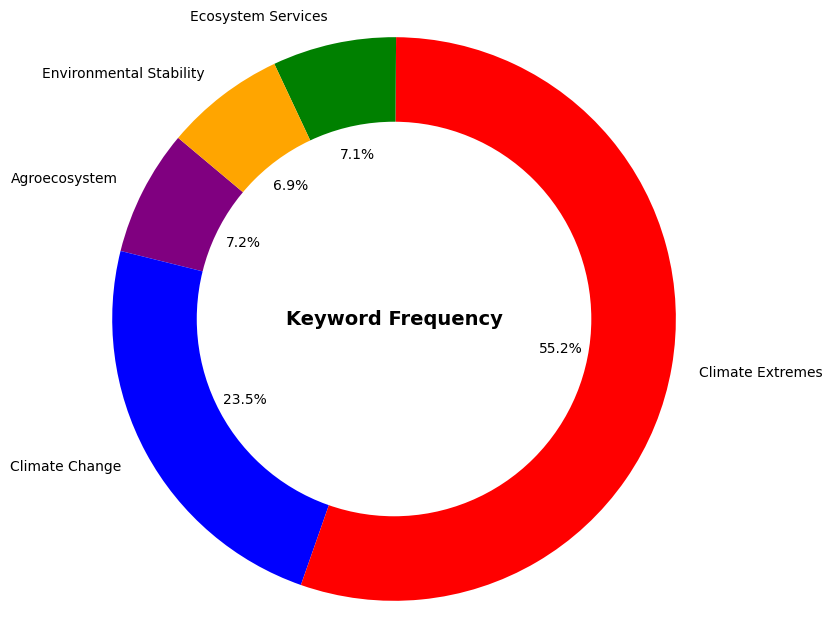

In [37]:
# Set up color palette for keyword groups
keyword_colors = {
    'Climate Change': 'blue',
    'Climate Extremes': 'red',
    'Ecosystem Services': 'green',
    'Agroecosystem': 'purple',
    'Environmental Stability': 'orange'
}

# Sort the DataFrame by 'Total Count' in descending order and select the top 20 words
top_20_words = df.sort_values(by='Total Count', ascending=False).head(20)

# Prepare data for Donut Chart
grouped_data = top_20_words.groupby('Keyword Group')['Total Count'].sum().reset_index()

# Create the Donut Chart
plt.figure(figsize=(8, 8))
plt.pie(grouped_data['Total Count'], labels=grouped_data['Keyword Group'], 
        colors=[keyword_colors[group] for group in grouped_data['Keyword Group']], 
        autopct='%1.1f%%', startangle=140)

# Draw center circle for donut effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Add the title in the center
center_title = 'Keyword Frequency'
plt.text(0, 0, center_title, horizontalalignment='center', verticalalignment='center', fontsize=14, weight='bold')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')
plt.show()


Extracting country-specific information

In [38]:

# Get a list of all country names using pycountry
country_list = [country.name.lower() for country in pycountry.countries]

def extract_country_from_pdf(pdf_path, country_list):
    """Extract country from specific sections and, if unknown, check the first author's institution section."""
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        found_country = None

        # Check the first page for the title (assuming it's the first set of bolded or prominent text)
        first_page_text = reader.pages[0].extract_text().lower()
        title = first_page_text.split('\n')[0]  # Assumption: Title is the first line on the first page
        
        # Check if the title contains any country name
        for country in country_list:
            if country in title:
                found_country = country.capitalize()
                break

        if found_country:
            return found_country  # Return early if country is found in title

        # Iterate through the rest of the text looking for country in keywords, abstract, and study area
        for page in range(len(reader.pages)):
            page_text = reader.pages[page].extract_text().lower()
            
            # Check for 'References' or 'Bibliography' to stop reading
            if 'references' in page_text or 'bibliography' in page_text:
                ref_index = page_text.find('references') if 'references' in page_text else page_text.find('bibliography')
                page_text = page_text[:ref_index]  # Only include text up to the found reference point

            # Search for the country in the specified sections in order
            for section in ['keywords:', 'abstract:', 'study area:']:
                if section in page_text:
                    section_text = page_text.split(section, 1)[1]
                    for country in country_list:
                        if country in section_text:
                            found_country = country.capitalize()
                            break
                if found_country:
                    break  # Stop searching further if the country is found

            if found_country:
                break  # Stop reading further pages if the country is found

        # If no country found, check the affiliation information for the first author on the first page
        if not found_country:
            # Look for common patterns in affiliation text (lines with 'university', 'institute', or similar keywords)
            for line in first_page_text.split('\n'):
                if any(keyword in line for keyword in ['university', 'institute', 'college', 'laboratory', 'school']):
                    # Check for country in the affiliation line
                    for country in country_list:
                        if country in line:
                            found_country = country.capitalize()
                            break
                if found_country:
                    break  # Stop if country is found in affiliation line

        return found_country if found_country else "Unknown"

def count_countries_in_folder(folder_path, country_list):
    """Count occurrences of each country from PDFs in a folder."""
    country_counts = Counter()  # Initialize counter for countries
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.pdf'):
            pdf_path = os.path.join(folder_path, filename)
            country = extract_country_from_pdf(pdf_path, country_list)
            country_counts[country] += 1  # Count the country (or "Unknown" if not found)
    
    return country_counts

# Specify the path to the folder containing PDFs
pdf_folder_path = r'C:\Users\DELL\Desktop\AGROECOSYSTEM\Touse'  # Update this with your actual folder path

# Count the occurrences of each country
country_counts = count_countries_in_folder(pdf_folder_path, country_list)

# Create a DataFrame and save it to a CSV file
csv_file_path = os.path.join(pdf_folder_path, 'country_counts_summary.csv')
df = pd.DataFrame(list(country_counts.items()), columns=['Country', 'Total Count'])
df.to_csv(csv_file_path, index=False)


In [39]:
df.head(5)

,Country,Total Count
0,Ghana,2
1,Italy,2
2,China,18
3,Brazil,3
4,Austria,3


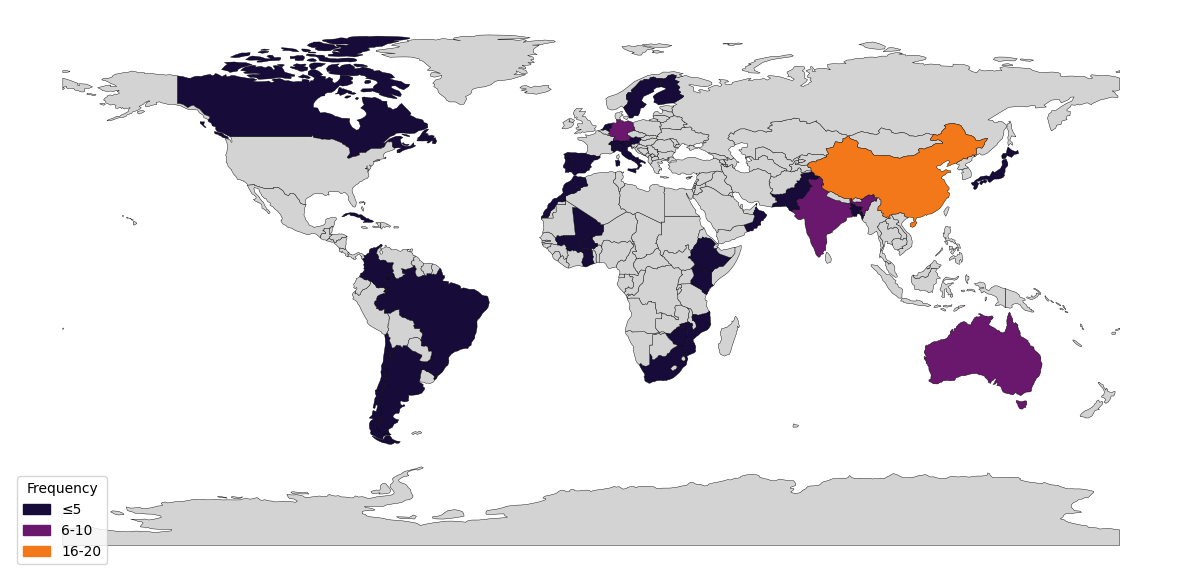

In [40]:

# Define the dataset URL and local path
naturalearth_url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
local_shapefile = "ne_110m_admin_0_countries.zip"

# Download the dataset if it doesn't exist
if not os.path.exists(local_shapefile):
    import requests
    print("Downloading Natural Earth dataset...")
    response = requests.get(naturalearth_url)
    with open(local_shapefile, "wb") as file:
        file.write(response.content)

# Load the world map from the downloaded file
world = gpd.read_file(f"zip://{local_shapefile}")

# Load the country count data
country_counts_df = pd.read_csv(r'C:\Users\DELL\Desktop\AGROECOSYSTEM\Touse\country_counts_summary.csv')

# Standardize country names for matching
world['country_lower'] = world['ADMIN'].str.strip().str.lower()
country_counts_df['Country'] = country_counts_df['Country'].str.strip().str.lower()

# Define the ranges and inferno colormap
ranges = {
    '≤5': (0, 5, 0.1),        
    '6-10': (6, 10, 0.3),
    '16-20': (16, 20, 0.7),    
}

# Function to assign color from inferno based on count
def get_color(count):
    for label, (low, high, color_value) in ranges.items():
        if low <= count <= high:
            return plt.cm.inferno(color_value), label
    return 'lightgrey', None  # Default for missing data

# Merge country counts with the world map
merged = world.set_index('country_lower').join(country_counts_df.set_index('Country'), how='left')

# Apply colors based on counts
merged['color'] = merged['Total Count'].apply(lambda x: get_color(x)[0] if pd.notna(x) else 'lightgrey')
merged['range_label'] = merged['Total Count'].apply(lambda x: get_color(x)[1] if pd.notna(x) else None)

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.plot(color=merged['color'], edgecolor='black', linewidth=0.3, ax=ax)
ax.axis('off')

# Legend using inferno colors
legend_patches = [mpatches.Patch(color=plt.cm.inferno(value), label=label) for label, (_, _, value) in ranges.items()]
plt.legend(handles=legend_patches, title="Frequency", loc='lower left')

plt.show()


Thank You.!!!